In [1]:
import numpy as np
import pandas as pd
import sys
import glob
import os,time,datetime

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10,5]
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# own dataclass
from imp import reload
import coronadataclass as cdc; reload(cdc);
import measureclass as mc; reload(mc);

np.seterr(divide = 'ignore', invalid = 'ignore');


In [2]:
r0data  = pd.read_csv('../data/Rvalues_wallinga_teunis_2days30-03-2020.csv')
r0data2 = pd.read_csv('../data/Rvalues_wallinga_teunis_2days_meansi4.41_std_sI3.17_30-03-2020.csv')
countrylist = list(set(r0data['country']))

jhudata     = cdc.CoronaData(download_data = False)
measuredata = mc.COVID19_measures(download_data = False, measure_level = 1, only_first_dates = False)

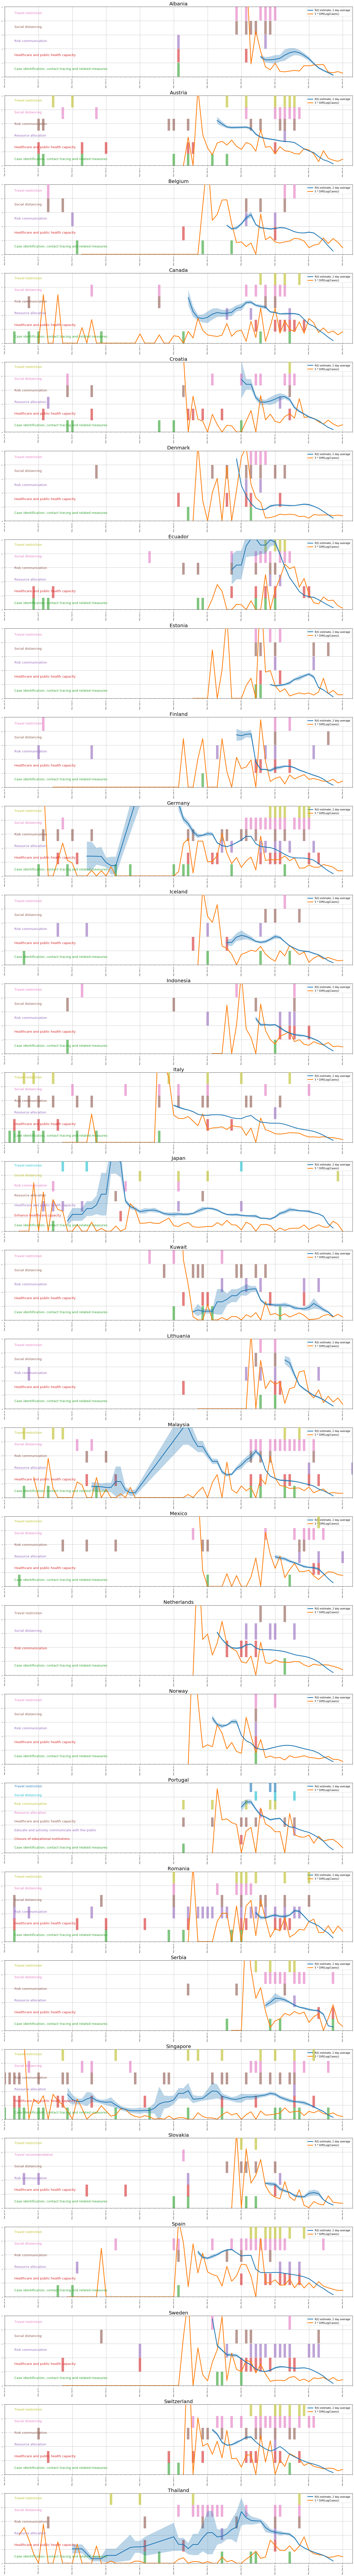

In [4]:
def ts(days = 0):
    return np.timedelta64(days,'D')


colornames       = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

days     = mdates.DayLocator()
weeks    = mdates.WeekdayLocator(byweekday = mdates.MO)
date_fmt = mdates.DateFormatter('%a, %b %d')


countrylist_r0fit = list(r0data['country'].unique())
countrylist_cshmeasures = measuredata.countrylist
countrylist = [c.capitalize() for c in countrylist_r0fit if c.capitalize() in countrylist_cshmeasures]

#print(countrylist_r0fit)
#print(countrylist_cshmeasures)
#print(countrylist)

i = 0
N = len(countrylist)
fig, axes = plt.subplots(N,1, figsize=(20, 5*N))
axes = axes.flatten()

ymaxval = 5



for country in countrylist:
        ax = axes[i]
        ax.xaxis.set_major_locator(weeks)
        ax.xaxis.set_major_formatter(date_fmt)
        ax.xaxis.set_minor_locator(days)
        
        ax.format_xdata = mdates.DateFormatter('%y-%m-%d')
        
        
        r0     = r0data[r0data['country'] == country]
        dates  = np.array(r0['startdate'], dtype = np.datetime64) + np.timedelta64(1,'D')
        r0mean = np.array(r0['Mean(R)'])
        r0std  = np.array(r0['Std(R)'])

        ax.plot(dates,r0mean,label='R(t) estimate, 2 day average',lw = 3,zorder = 110)
        ax.fill_between(dates,r0mean-r0std,r0mean+r0std,alpha = .3, zorder = 105)

        #r0     = r0data2[r0data2['country'] == country]
        #dates  = np.array(r0['startdate'], dtype = np.datetime64) + np.timedelta64(1,'D')
        #r0mean = np.array(r0['Mean(R)'])
        #r0std  = np.array(r0['Std(R)'])

        #ax.plot(dates,r0mean,label='Rvalues_wallinga_teunis_2days_meansi4.41_std_sI3.17_30-03-2020.csv')
        #ax.fill_between(dates,r0mean-r0std,r0mean+r0std,alpha = .3)
        
        jhucountry = jhudata.CountryData(country)
        dates_jhu  = [datetime.datetime.strptime(a,'%m/%d/%y') for a in np.array(jhucountry['Date'])[1:]]
        conf_jhu   = np.diff(np.log(jhucountry['Confirmed']))
        
        ax.plot(dates_jhu, 5 * conf_jhu, label = '5 * Diff(Log(Cases))', lw = 3, zorder = 109)
        
        countrymeasures = measuredata.GetCountryData(country)
        if not countrymeasures is None:
            count_measures = len(countrymeasures) * 1.
            for j, (mname, datelist) in enumerate(countrymeasures.items()):
                ax.annotate(mname, [datetime.datetime.strptime('22/1/2020','%d/%m/%Y'),ymaxval * (j+.5)/count_measures], c = colornames[(j+2) % len(colornames)], fontsize = 13, zorder = 120)
                for date in datelist:
                    #print(date)
                    try:
                        ax.plot([datetime.datetime.strptime(date,'%d/%m/%Y'),datetime.datetime.strptime(date,'%d/%m/%Y')],[ymaxval * (j+.1)/count_measures,ymaxval * (j+.9)/count_measures], c = colornames[(j+2) % len(colornames)], lw = 10, alpha = .6, zorder = 100)
                    except:
                        continue
        
        ax.legend(loc = 'upper right')
        ax.tick_params(labelrotation=90, labelsize=6)
        ax.set_title(country,fontsize = 20)
        ax.set_ylim([0,ymaxval])
        ax.set_xlim([datetime.datetime.strptime('1/20/20','%m/%d/%y'), datetime.datetime.today()])
        ax.grid()
        #ax.legend()
        i += 1
    
#plt.show()
fig.tight_layout()
plt.savefig('comparison_measures_r0t.pdf')